# Transfer Learning with TensorFlow Part 1 : Feature Extraction

Two main benefits:
- Can leverage an existing neural network architecture proven to work on problems similar to our own.
- Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
!nvidia-smi

Sat Aug 17 15:26:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce 840M            Off | 00000000:03:00.0 Off |                  N/A |
| N/A   54C    P8              N/A /  19W |      6MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import tf_keras

In [5]:
tf.config.list_physical_devices(), tf.config.list_logical_devices()

2024-08-18 18:59:32.553291: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [LogicalDevice(name='/device:CPU:0', device_type='CPU')])

## Downloading and becoming one with the data

In [7]:
# Get the data (10 percent of 10 food classes from Food101)
import zipfile

# Dwonload the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2024-08-17 15:34:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.206.91, 142.250.186.155, 142.250.184.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.206.91|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-08-17 15:34:27 ERROR 403: Forbidden.



In [9]:
# Unzip the downloading file
zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [5]:
# How many images in each folder?
import os

# Walk through the directort and list the number of files in each directory
for dirpath, dirnames, dirfiles in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(dirfiles)} files in {dirpath}\n')
    

There are 2 directories and 0 files in 10_food_classes_10_percent

There are 10 directories and 0 files in 10_food_classes_10_percent/test

There are 0 directories and 250 files in 10_food_classes_10_percent/test/fried_rice

There are 0 directories and 250 files in 10_food_classes_10_percent/test/hamburger

There are 0 directories and 250 files in 10_food_classes_10_percent/test/ramen

There are 0 directories and 250 files in 10_food_classes_10_percent/test/pizza

There are 0 directories and 250 files in 10_food_classes_10_percent/test/sushi

There are 0 directories and 250 files in 10_food_classes_10_percent/test/chicken_curry

There are 0 directories and 250 files in 10_food_classes_10_percent/test/grilled_salmon

There are 0 directories and 250 files in 10_food_classes_10_percent/test/chicken_wings

There are 0 directories and 250 files in 10_food_classes_10_percent/test/steak

There are 0 directories and 250 files in 10_food_classes_10_percent/test/ice_cream

There are 10 directori

In [6]:
os.listdir('10_food_classes_10_percent')

['test', 'train']

## Creating data loaders (preparing the data)

Wi'll use the `ImageDataGenerator` class to load in our images in batches

In [20]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

BATCH_SIZE=32
IMAGE_SHAPE=(224,224)

train_dir='10_food_classes_10_percent/train'
test_dir='10_food_classes_10_percent/test'

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                       batch_size=BATCH_SIZE,
                                                       target_size=IMAGE_SHAPE,
                                                       class_mode='categorical')

print('Testing images:')
test_data=test_datagen.flow_from_directory(test_dir,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=IMAGE_SHAPE,
                                                     class_mode='categorical')


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

- **Experiment tracking with TensorBoard** - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.

- **Model checkpointing** - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.

- **Early stopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.



In [8]:
# Create TensorBoard callback (functionized because each model need a new one )
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    
    log_dir=dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    
    tensorboard_callback=tf_keras.callbacks.TensorBoard(log_dir)
    
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

## Creating models using TensorFlow Hub

In [22]:
# Let's compare the following two models
resnet_url="https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [10]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import tf_keras
  

In [21]:
# Create function to create a model from url

def create_model(model_url, num_classes=10):
    """
    
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in output layer,
        should be equal to number of target classes, default 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature
      extractor layer and Dense output layer with num_classes outputs.
      
    """
        
    # Download the pretrained model and save it as a keras layer
    feature_extractor_layer=hub.KerasLayer(model_url,
                                           input_shape=IMAGE_SHAPE + (3,),
                                           trainable=False, # Freeze the already learned pattern
                                           name= 'feature_extraction_layer' )
                                           
    
    # Create our own model
    model=tf_keras.Sequential([
        feature_extractor_layer,
        tf_keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    
    #model.build([None, 224, 224, 3]) 

    return model

In [12]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

## Creating and testing RezNet TensorFlow Hub Feature Extraction model

In [17]:
'''

efficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

# Create our own model
efficientnet_model=tf_keras.Sequential([
    
                    hub.KerasLayer(efficientnet_url,
                                   input_shape=IMAGE_SHAPE + (3,),
                                   trainable=False, # Freeze the already learned pattern
                                   name= 'feature_extraction_layer' )

                    tf_keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    
'''

'\n\nefficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"\n\n# Create our own model\nefficientnet_model=tf_keras.Sequential([\n    \n                    hub.KerasLayer(efficientnet_url,\n                                   input_shape=IMAGE_SHAPE + (3,),\n                                   trainable=False, # Freeze the already learned pattern\n                                   name= \'feature_extraction_layer\' )\n\n                    tf_keras.layers.Dense(num_classes, activation=\'softmax\', name=\'output_layer\')\n    ])\n    \n'

In [25]:
def plot_loss_curves(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,6))

    plt.subplot(121)
    #plt.figure(figsize=(12,6))
    plt.plot(tf.range(len(history.history['loss'])), history.history['accuracy'], label='training_accuracy')
    plt.plot(tf.range(len(history.history['loss'])), history.history['val_accuracy'], label='val_accuracy')

    plt.xlabel('epochs')
    plt.ylabel('')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(122)
    #plt.figure(figsize=(12,6))
    plt.plot(tf.range(len(history.history['loss'])), history.history['loss'], label='training_loss')
    plt.plot(tf.range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')

    plt.xlabel('epochs')
    plt.ylabel('')
    plt.title('Loss')
    plt.legend()

In [14]:
# Create ResNet model

resnet_model=create_model(resnet_url, train_data_10_percent.num_classes)


2024-08-18 20:09:26.858984: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
train_data_10_percent.num_classes

10

In [16]:
# Compile the ResNet model
resnet_model.compile(optimizer=tf_keras.optimizers.Adam(),
                     loss=tf_keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])


In [23]:
# Fit the ResNet model
resnet_history= resnet_model.fit(train_data_10_percent,
                                 #batch_size=32,
                                 steps_per_epoch=len(train_data_10_percent),
                                 epochs=5,
                                 validation_data=test_data,
                                 #validation_batch_size=32,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20240818-201709
Epoch 1/5


2024-08-18 20:17:15.551250: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-08-18 20:17:16.578216: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-08-18 20:17:16.982469: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-08-18 20:17:17.764957: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-08-18 20:17:18.031081: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


24/24 [==============================] - 375s 16s/step - loss: 2.0413 - accuracy: 0.3520 - val_loss: 1.2959 - val_accuracy: 0.5544
Epoch 2/5
24/24 [==============================] - 405s 17s/step - loss: 0.9723 - accuracy: 0.7080 - val_loss: 0.8815 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 441s 19s/step - loss: 0.6586 - accuracy: 0.8080 - val_loss: 0.7800 - val_accuracy: 0.7384
Epoch 4/5
24/24 [==============================] - 415s 18s/step - loss: 0.4933 - accuracy: 0.8773 - val_loss: 0.7086 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 417s 18s/step - loss: 0.3968 - accuracy: 0.9147 - val_loss: 0.6926 - val_accuracy: 0.7744


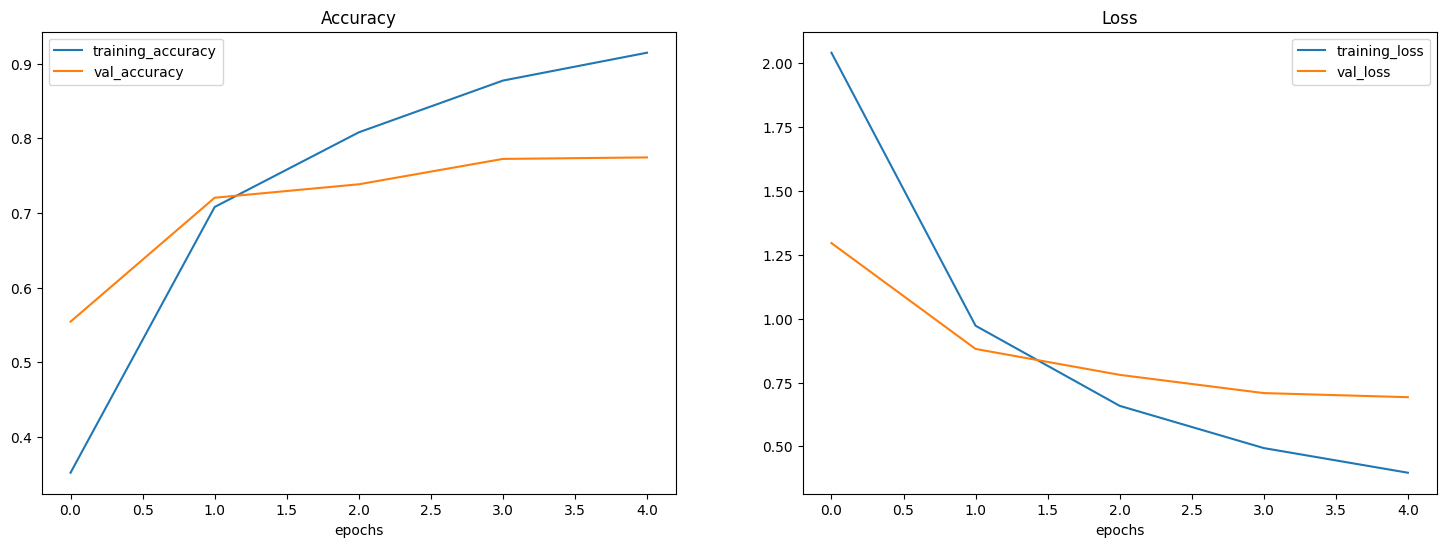

In [26]:
plot_loss_curves(resnet_history)

In [27]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [18]:
# Create EfficientNet model
efficientnet_model=create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

In [28]:
# Compile EfficientNet model
efficientnet_model.compile(optimizer=tf_keras.optimizers.Adam(),
                           loss=tf_keras.losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history= efficientnet_model.fit(train_data_10_percent,
                                             steps_per_epoch=len(train_data_10_percent),
                                             epochs=5,
                                             validation_data=test_data,
                                             validation_steps=len(test_data),
                                             callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240818-210156
Epoch 1/5
24/24 [==============================] - 197s 8s/step - loss: 1.8143 - accuracy: 0.4627 - val_loss: 1.2680 - val_accuracy: 0.7320
Epoch 2/5
24/24 [==============================] - 179s 8s/step - loss: 1.0696 - accuracy: 0.7640 - val_loss: 0.8400 - val_accuracy: 0.8312
Epoch 3/5
24/24 [==============================] - 255s 11s/step - loss: 0.7345 - accuracy: 0.8373 - val_loss: 0.6948 - val_accuracy: 0.8544
Epoch 4/5
24/24 [==============================] - 197s 9s/step - loss: 0.6119 - accuracy: 0.8573 - val_loss: 0.5993 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 188s 8s/step - loss: 0.5006 - accuracy: 0.8907 - val_loss: 0.5536 - val_accuracy: 0.8640


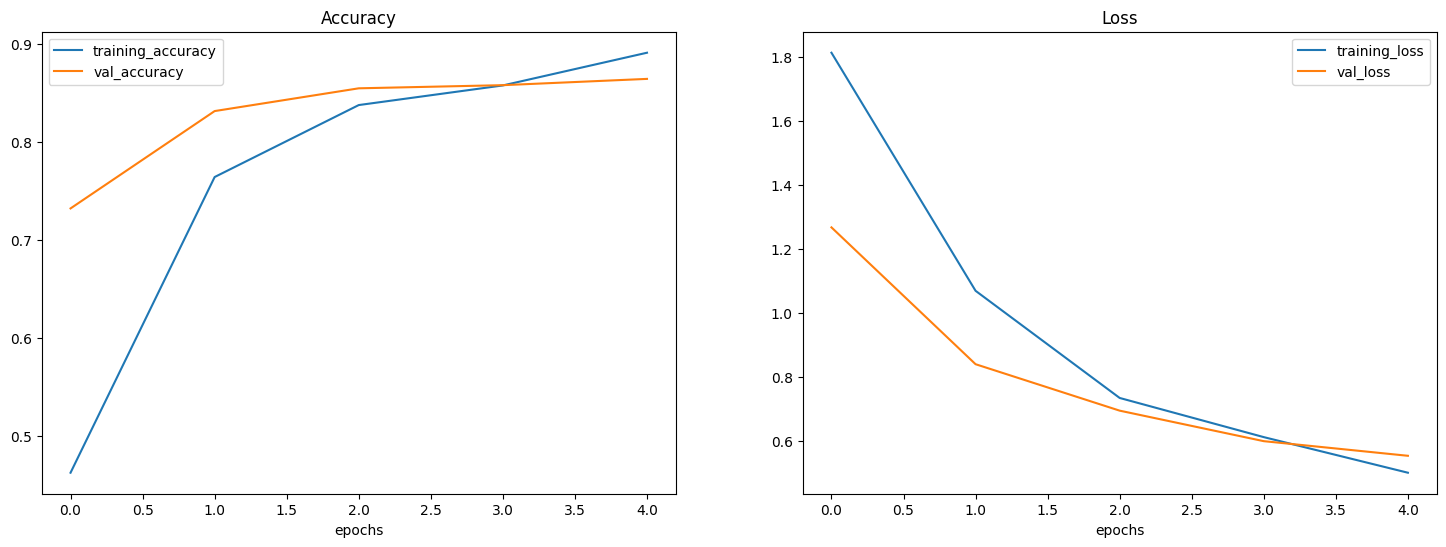

In [29]:
plot_loss_curves(efficientnet_history)

In [30]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [2]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir ./tensorflow_hub/

In [36]:
%tensorboard list

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-08-18 22:19:55.227050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 22:19:55.250374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 22:19:55.257205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 22:19:55.272753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropri